In [ ]:
using Pkg
Pkg.activate("NB03")
Pkg.update()

In [ ]:
using LinearAlgebra, Plots
using RDatasets, Optim

# Modelle

## Der Datensatz
Wir laden den Datensatz `cars` aus `RDatasets` und lassen uns die Variablennamen anzeigen.

In [3]:
data_cars = dataset("datasets", "cars");
names(data_cars)

2-element Vector{String}:
 "Speed"
 "Dist"

Hier ist eine Zusammenfassung der Daten:

In [4]:
describe(data_cars)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,Speed,15.4,4,15.0,25,0,Int64
2,Dist,42.98,2,36.0,120,0,Int64


Die Anzahl der Datenpunkte ist

In [5]:
N = size(data_cars, 1)

50

Wir haben also zwei Merkmale `Speed` und `Dist` und $N$ Datenpunkte.

Jeder Datenpunkt $(x,y)$ besteht also aus einem Geschwindigkeitswert $x$ und einem Abstandswert $y$. Diese Werte wurden wie folgt gemessen: Ein Fahrzeug fährt mit Geschwindigkeit $x$ und braucht dann einen Bremsweg der Länge $y$ bis es zum Stehen kommt. 

Schauen wir uns die Daten einmal an:

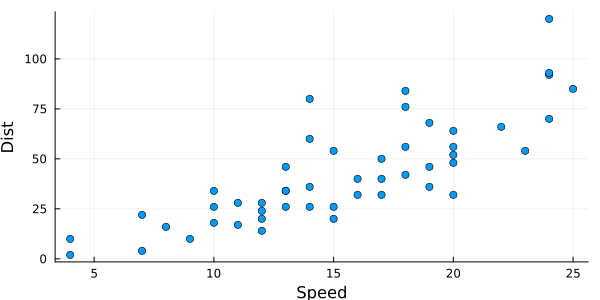

In [6]:
scatter(data_cars[:,"Speed"], data_cars[:,"Dist"], legend=false, size = (600,300),
            xlabel = "Speed",
            ylabel = "Dist")

Es sieht aus als könnte ein lineares Modell die Daten gut beschreiben.

## Das lineare Modell

Das lineare Modell für die Daten $(x,y)\in\mathbb R \times \mathbb R$ ist 

$$f_\theta(x) =  a x + b,$$

wobei $x$ `Speed` und $y=f_\theta(x)$ `dist` repräsentiert.

$\theta =(a,b)\in\mathbb R^2$ sind die Parameter.

Wir wollen nun $\theta$ anhand der Daten lernen.

## Aufteilen in Trainings- und Testdaten

Wir wählen zufällig $75\%$ der Datenpunkte aus. Dies sind die Trainingsdaten. Der Rest sind Testdaten.

In [7]:
N_train = round(Int, N * 0.75)
train_idx = rand(1:N, N_train)
test_idx = setdiff(1:N, train_idx);

`X` bezeichnet jetzt die `Speed` Trainingsdaten und `Y` die Abstandsdaten.

In [8]:
X = data_cars[train_idx, "Speed"]
Y = data_cars[train_idx, "Dist"]
X_test = data_cars[test_idx, "Speed"] # wir definieren auch Testdaten
Y_test = data_cars[test_idx, "Dist"];

## Implementation des Modells

Das lineare Modell ist $f_\theta(x) = ax+b$ mit $x\in\mathbb R$ und $\theta = (a,b)$.

Wir wählen `Number` als Objekttyp für $x$, da $x\in\mathbb R$. 

In [9]:
f(x::Number, θ) = θ[1] * x + θ[2];

Wir werden jetzt $f$ per [Mutiple Dispatch](https://docs.julialang.org/en/v1/manual/methods/) erweitern: Falls $x$ ein Objekt vom `Number` ist, dann nehmen wir die erste Definition. Falls $X$ ein `Vector` ist, dann definieren wir $f_\theta(X) := (f(x))_{x\in X}$.

In [10]:
f(X::Vector, θ) = [f(x, θ) for x in X];

In [11]:
methods(f)

# 2 methods for generic function "f" from Main:
 [1] f(X::Vector, θ)
     @ In[10]:1
 [2] f(x::Number, θ)
     @ In[9]:1

## Verlustfunktion und empirisches Risiko

In diesem Beispiel nehmen wir als Verlustfunktion den quadratischen Abstand

$$\ell(\hat y, y ) = ( \hat y - y )^2$$

Das empirische Risiko ist dann 

$$R(\theta) =\frac{1}{\text{Anzahl Trainingsdaten}}\, \sum_{(x,y) \text{ in den Trainingsdaten }} \ell(f_\theta(x),y).$$

In [12]:
ℓ(ŷ, y) = (ŷ - y)^2 
R(θ, X, Y, f) = sum(ℓ(f(x,θ), y) for (x,y) in zip(X, Y)) / length(X)

R (generic function with 1 method)

## Training

Wir finden nun $\theta$, indem wir $R(\theta)$ minimieren:

In [13]:
o = optimize(θ -> R(θ, X, Y, f), rand(2)) # rand(2) ist ein zufälliger Startpunkt für den Optimierungsalgorithmus
θ = Optim.minimizer(o);
print("θ = ", θ)

θ = [3.4663589773349783, -11.111065337326266]

Wir prüfen, ob das Risiko auf den Testdaten im Vergleich zu den Trainingsdaten ist:

In [14]:
println("Risiko der Trainingsdaten = ", R(θ, X, Y, f))
println("Risiko der Testdaten = ", R(θ, X_test, Y_test, f))

Risiko der Trainingsdaten = 214.46939766652687
Risiko der Testdaten = 215.83506728604536


Zuletzt plotten wir unser Ergebnis:

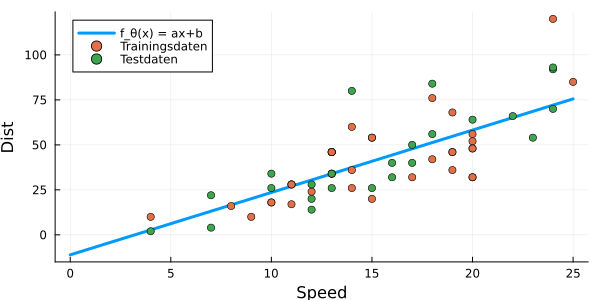

In [15]:
p = collect(0:0.5:25)

plot(p, f(p, θ), lw = 3, label = "f_θ(x) = ax+b")
#plot!(p, f(p, randn(2)), lw = 3, label = "Zufällige Parameter")
scatter!(X, Y, label="Trainingsdaten", 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(X_test, Y_test, label="Testdaten",
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))


## Vorhersagen mit Hilfe des trainierten Modells

Der gelernte Parameter $\theta$ definiert eine Funktion $f_\theta$, die wir nun benutzen können, um `Dist` gegeben `Speed` vorherzusagen.

Hier ist ein Beispiel für `Speed = 10` und `Speed = 20`:

In [16]:
println("Speed = 10: Dist = ", f(10, θ))
println("Speed = 20: Dist = ", f(20, θ))

Speed = 10: Dist = 23.552524436023518
Speed = 20: Dist = 58.2161142093733


## Ein simples statistisches Modell

Es sieht so aus, als würden sich die Datenpunkte relativ gleichmäßig um die Linie, die von unserem Modell vorhergesagt wird, verteilen. Um der Unsicherheit Rechnung zu tragen, können wir unser (deterministisches) Modell in ein statistisches Modell umwandeln, indem wir 

$$y\sim N(f_\theta(x), \sigma^2),\qquad \sigma^2 = 100$$

setzen. D.h., $y$ ist normalverteilt mit Mittelwert $f_\theta(x) = ax + b$ und Varianz $\sigma^2 = 100$. Die Wahrscheinlichkeitsdichte von $y$ ist dann

$$P_\theta(y\mid x) = \frac{1}{\sqrt{2\pi\sigma^2}}\, e^{\frac{1}{2\sigma^2} (y - f_\theta(x))^2}.$$

Wir generieren einige Vorhersagen mit Hilfe dieses Modells und plotten das Ergebnis: 

In [17]:
sigma = 10
println("Speed = 20: Dist = ", f(10, θ) + randn() * sigma^2) 

Speed = 20: Dist = 76.81938005326953


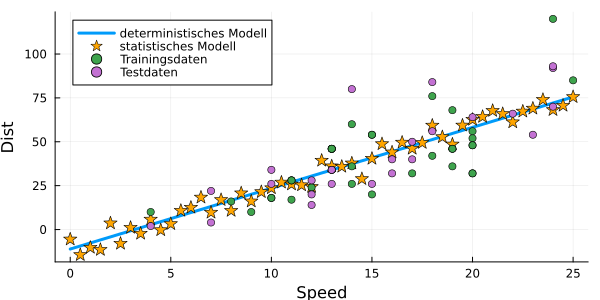

In [18]:
q = f(p, θ) + randn(length(p)) * 5

plot(p, f(p, θ), lw = 3, label = "deterministisches Modell")
scatter!(p, q, label="statistisches Modell", markershape=:star5, 
            markercolor = :orange, markersize = 7,
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(X, Y, label="Trainingsdaten", 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(X_test, Y_test, label="Testdaten",
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))

## Das quadratische Modell

Eine alternative zum linearen Modell ist das quadratische Modell

$$f_\theta(x) = ax^2 + bx + c,$$

mit Parametern $\theta = (a,b,c)$. 

Wir definieren das quadratische Modell genau wie zuvor das lineare Modell


In [19]:
f2(x::Number, θ) = θ[1] * x^2 + θ[2] * x + θ[3]
f2(X::Vector, θ) = [f2(x, θ) for x in X];

und trainieren es, indem wir das empirische Risiko minimieren:

In [20]:
o2 = optimize(θ -> R(θ, X, Y, f2), rand(3)) # rand(2) ist ein zufälliger Startpunkt für den Optimierungsalgorithmus
θ2 = Optim.minimizer(o2);
print("θ = ", θ2)

θ = [0.10576937174382434, 0.25871326329487976, 11.045446333546971]

Das empirischen Risiken für den von uns berechneten Parameter sind dann:

In [21]:
println("Risiko der Trainingsdaten = ", R(θ2, X, Y, f2))
println("Risiko der Testdaten = ", R(θ2, X_test, Y_test, f2))

Risiko der Trainingsdaten = 206.71199477131137
Risiko der Testdaten = 216.56809814249576


Wieder plotten wir das Ergebnis:

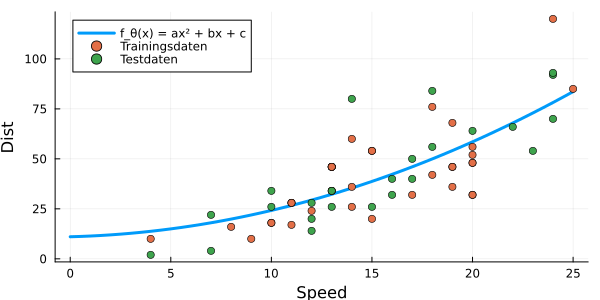

In [22]:
p = collect(0:0.5:25)

plot(p, f2(p, θ2), lw = 3, label = "f_θ(x) = ax² + bx + c")
scatter!(X, Y, label="Trainingsdaten", 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(X_test, Y_test, label="Testdaten",
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))

## Ein weiteres Modell

Zuletzt definieren wir ein weiteres *nichtlineares* Modell $f_\theta:\mathbb R\to\mathbb R$.

Dazu sei $\sigma(z) = \max\{0,z\}$. $\sigma$ heisst auch ReLU (Rectified Linear Unit) Funktion.

Dann setzen wir 

$$f_\theta(x) = \sigma(A_2 v + b_2),\quad v = \sigma(u)=\begin{pmatrix}\sigma(u_1)\\ \sigma(u_2)\end{pmatrix},\quad u = A_1 x + b_1\in\mathbb R^2,$$

wobei 

$$A_1 = \begin{pmatrix} \theta_1\\\theta_2\end{pmatrix}\in\mathbb R^{2},\quad  b_1 = \begin{pmatrix} \theta_3\\\theta_4\end{pmatrix}\in\mathbb R^2$$  

und 

$$A_2= \begin{pmatrix} \theta_5 & \theta_6\end{pmatrix}\in\mathbb R^{1\times 2},\quad b_2 = \theta_7\in\mathbb R.$$

Die Parameter sind dann $\theta = (A_1,b_1,A_2,b_2)$.

Dies ist ein sogenannte künstliches neuronales Netz.

In [23]:
σ(z) = max(0, z)
function f3(x::Number, θ)
    A1 = [θ[1];
          θ[2]];
    b1 = [θ[3];
          θ[4]];
    A2 = [θ[5] θ[6]];
    b2 = [θ[7]]
        
    y = σ.(A1 * x + b1)
    z = σ.(A2 * y + b2)
    
    z[1]
end
f3(X::Vector, θ) = [f3(x, θ) for x in X];

Wieder optimieren wir:

In [24]:
o3 = optimize(θ -> R(θ, X, Y, f3), rand(7))
θ3 = Optim.minimizer(o3);
print("θ3 = ", θ3)

θ3 = [7.2299770553672085, 0.7856776547796983, -1.9483054252189795, 2.175055689900122, 0.9842827799703677, -4.645675629471358, 0.9114253263403274]

und prüfen das empirische Risiko auf den Daten:

In [25]:
println("Risiko der Trainingsdaten = ", R(θ3, X, Y, f3))
println("Risiko der Testdaten = ", R(θ3, X_test, Y_test, f3))

Risiko der Trainingsdaten = 214.46939765376968
Risiko der Testdaten = 215.8361036287249


Zuletzt wieder ein Plot:

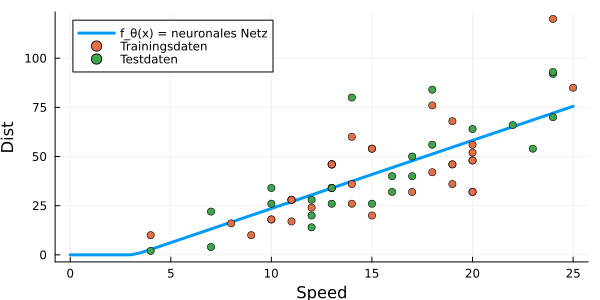

In [26]:
p = collect(0:0.5:25)
plot(p, f3(p, θ3), lw = 3, label = "f_θ(x) = neuronales Netz")
scatter!(X, Y, label="Trainingsdaten", 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(X_test, Y_test, label="Testdaten",
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))